In [1]:
# from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Import helper functions
from mlfromscratch.supervised_learning import PolynomialRidgeRegression
from mlfromscratch.utils import k_fold_cross_validation_sets, normalize, mean_squared_error
from mlfromscratch.utils import train_test_split, polynomial_features, Plot

In [2]:

# Load temperature data
data = pd.read_csv('../data/TempLinkoping2016.txt', sep="\t")

time = np.atleast_2d(data["time"].values).T
temp = data["temp"].values

X = time # fraction of the year [0, 1]
y = temp

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [3]:
poly_degree = 15

# Finding regularization constant using cross validation
lowest_error = float("inf")
best_reg_factor = None
print ("Finding regularization constant using cross validation:")


Finding regularization constant using cross validation:


In [53]:
from mlfromscratch.utils import shuffle_data
k=10
shuffle=True
""" Split the data into k sets of training / test data """
if shuffle:
    X, y = shuffle_data(X_train, y_train)

In [6]:
n_samples = len(y)
left_overs = {}
n_left_overs = (n_samples % k)
if n_left_overs != 0:
    left_overs["X"] = X[-n_left_overs:]
    left_overs["y"] = y[-n_left_overs:]
    X = X[:-n_left_overs]
    y = y[:-n_left_overs]

In [44]:
X_split = np.split(X, k)
y_split = np.split(y, k)
sets = []

In [45]:
for i in range(k):
    X_test, y_test = X_split[i], y_split[i]
    X_train = np.concatenate(X_split[:i] + X_split[i + 1:], axis=0)
    y_train = np.concatenate(y_split[:i] + y_split[i + 1:], axis=0)
    sets.append([X_train, X_test, y_train, y_test])

In [46]:

# Add left over samples to last set as training samples
if n_left_overs != 0:
    np.append(sets[-1][0], left_overs["X"], axis=0)
    np.append(sets[-1][2], left_overs["y"], axis=0)

S = sets

In [4]:
k = 10
for reg_factor in np.arange(0, 0.1, 0.01):
    cross_validation_sets = k_fold_cross_validation_sets(X_train, y_train, k=k)
    mse = 0
    for _X_train, _X_test, _y_train, _y_test in cross_validation_sets:
        model = PolynomialRidgeRegression(degree=poly_degree, 
                                        reg_factor=reg_factor,
                                        learning_rate=0.001,
                                        n_iterations=10000)
        model.fit(_X_train, _y_train)
        y_pred = model.predict(_X_test)
        _mse = mean_squared_error(_y_test, y_pred)
        mse += _mse
    mse /= k

    # Print the mean squared error
    print ("\tMean Squared Error: %s (regularization: %s)" % (mse, reg_factor))

    # Save reg. constant that gave lowest error
    if mse < lowest_error:
        best_reg_factor = reg_factor
        lowest_error = mse

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (10, 4) + inhomogeneous part.

Mean squared error: 10.333945314262417 (given by reg. factor: 0.0)


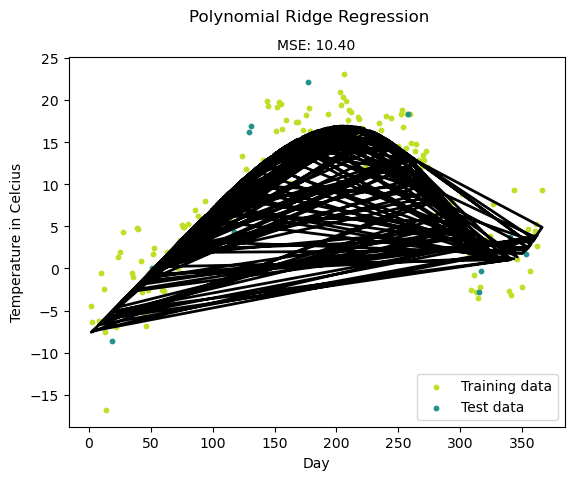

In [48]:
# Make final prediction
model = PolynomialRidgeRegression(degree=poly_degree, 
                                reg_factor=best_reg_factor,
                                learning_rate=0.001,
                                n_iterations=10000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print ("Mean squared error: %s (given by reg. factor: %s)" % (lowest_error, best_reg_factor))

y_pred_line = model.predict(X)

# Color map
cmap = plt.get_cmap('viridis')

# Plot the results
m1 = plt.scatter(366 * X_train, y_train, color=cmap(0.9), s=10)
m2 = plt.scatter(366 * X_test, y_test, color=cmap(0.5), s=10)
plt.plot(366 * X, y_pred_line, color='black', linewidth=2, label="Prediction")
plt.suptitle("Polynomial Ridge Regression")
plt.title("MSE: %.2f" % mse, fontsize=10)
plt.xlabel('Day')
plt.ylabel('Temperature in Celcius')
plt.legend((m1, m2), ("Training data", "Test data"), loc='lower right')
plt.show()

